In [0]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from skimage.transform import resize

In [0]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
del X, y

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1)) / 255.
y_train = y_train.astype(int)

X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1)) / 255.
y_test = y_test.astype(int)

In [0]:
imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow(X_train, y_train, shuffle=True, batch_size=32)
val = imagegen.flow(X_test, y_test, shuffle=False, batch_size=32)

In [0]:
class RevNet(tf.keras.Model):
  def __init__(self, without_nuisance=False):
    super(RevNet, self).__init__()
    self._encoder = self._construct_encoder()
    self._decoder = self._construct_decoder()
    self._prediction = self._construct_prediction()
    self._without_nuisance = without_nuisance
    if not without_nuisance:
      self._nuisance_prediction = self._construct_prediction_nuisance()

  def _construct_encoder(self):
    encoder = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
            tf.keras.layers.Dense(28*28, activation="sigmoid"),
            tf.keras.layers.Dense(28*28, activation="sigmoid")
        ],
        name="encoder")
    return encoder

  def _construct_decoder(self):
    decoder = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(28*28, activation="sigmoid", input_shape=(28*28,)),
            tf.keras.layers.Dense(28*28)
        ],
        name="decoder")
    return decoder

  def _construct_prediction(self):
    prediction = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(10, input_shape=(10,))
        ],
        name="prediction")
    return prediction
  
  def _construct_prediction_nuisance(self):
    nuisance_prediction = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(10, input_shape=(28*28-10,))
        ],
        name="nuisance_prediction")
    return nuisance_prediction

  def call(self, inputs, training=True):
    predicted_array = self._encoder(inputs, training)
    logits = predicted_array[:, :10]
    nuisance = predicted_array[:, 10:]
    pred_logits = self._prediction(logits)
    pred_image = self._decoder(predicted_array, training)
    pred_nuisance = None
    if not self._without_nuisance:
      pred_nuisance = self._nuisance_prediction(nuisance)

    return logits, nuisance, pred_logits, pred_image, pred_nuisance

In [59]:
model = RevNet(without_nuisance=True)
model.build((1, 28, 28, 1))
model.summary()

Model: "rev_net_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 784)               1230880   
_________________________________________________________________
decoder (Sequential)         (None, 784)               1230880   
_________________________________________________________________
prediction (Sequential)      (None, 10)                110       
Total params: 2,461,870
Trainable params: 2,461,870
Non-trainable params: 0
_________________________________________________________________


Epoch:  20
Training loss mse: 5.9786754036395e-07, Training loss ce: 0.3726981580257416, Training acc over epoch: 0.8888393044471741
Val loss mse: 5.808809646623558e-07, Val loss ce: 0.3679417073726654, Val acc over epoch: 0.8937857151031494


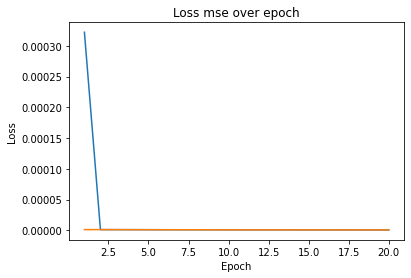

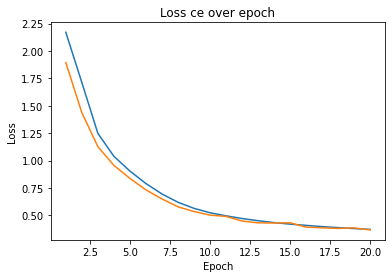

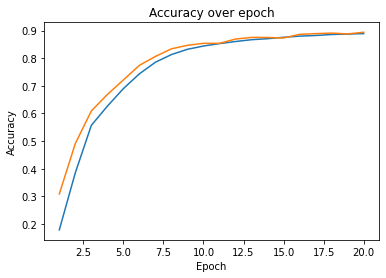

In [16]:
from IPython.display import clear_output
from tqdm import tqdm

max_val_acc = None

train_losses_mse = []
val_losses_mse = []

train_losses_ce = []
val_losses_ce = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

for epoch in range(20):
    train_mean_loss_mse = tf.keras.metrics.Mean()
    train_mean_loss_ce = tf.keras.metrics.Mean()
    val_mean_loss_mse = tf.keras.metrics.Mean()
    val_mean_loss_ce = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(len(X_train) / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        with tf.GradientTape() as tape:
          logits, nuisance, pred_logits, pred_images, _ = model(x_batch_train, training=True)

          ce_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
          cross_ent = ce_fn(y_true=y_batch_train, y_pred=pred_logits)

          mse = tf.keras.losses.MSE(pred_images, tf.reshape(x_batch_train, (-1, 28*28)))

          loss = mse + cross_ent

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_acc_metric(y_batch_train, pred_logits)
        train_mean_loss_mse(mse)
        train_mean_loss_ce(cross_ent)

    for step in range(int(np.ceil(len(X_test) / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, nuisance, pred_logits, pred_images, _ = model(x_batch_val, training=False)

        ce_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        cross_ent = ce_fn(y_true=y_batch_val, y_pred=pred_logits)

        mse = tf.keras.losses.MSE(pred_images, tf.reshape(x_batch_val, (-1, 28*28)))

        val_acc_metric(y_batch_val, pred_logits)
        val_mean_loss_mse(mse)
        val_mean_loss_ce(cross_ent)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss mse: %s, Training loss ce: %s, Training acc over epoch: %s' % (float(train_mean_loss_mse.result()), 
                                                                                        float(train_mean_loss_ce.result()),
                                                                                        float(train_acc_metric.result())))
    print('Val loss mse: %s, Val loss ce: %s, Val acc over epoch: %s' % (float(val_mean_loss_mse.result()),
                                                                         float(val_mean_loss_ce.result()),
                                                                         float(val_acc_metric.result())))

    train_losses_mse.append(train_mean_loss_mse.result())
    val_losses_mse.append(val_mean_loss_mse.result())

    plt.plot(range(1, epoch + 2), train_losses_mse)
    plt.plot(range(1, epoch + 2), val_losses_mse)
    plt.title("Loss mse over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_losses_ce.append(train_mean_loss_ce.result())
    val_losses_ce.append(val_mean_loss_ce.result())

    plt.plot(range(1, epoch + 2), train_losses_ce)
    plt.plot(range(1, epoch + 2), val_losses_ce)
    plt.title("Loss ce over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/mnist.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_mnist.hdf5")

In [0]:
def choose_images(model, img_gen=None, threshold=0.):
    while True:
      logit_img, logit_class = img_gen.next()
      nuisance_img, nuisance_class = img_gen.next()

      logit_img = tf.cast(logit_img, tf.float32)
      nuisance_img = tf.cast(nuisance_img, tf.float32)
      
      logit_class = int(logit_class[0])
      nuisance_class = int(nuisance_class[0])

      logit_logits, logit_nuisance, logit_pred, logit_image, _ = model(logit_img, training=False)
      nuisance_logits, nuisance_nuisance, nuisance_pred, nuisance_image, _ = model(nuisance_img, training=False)
      
      logit_pred = tf.nn.softmax(logit_pred).numpy()[0]
      nuisance_pred = tf.nn.softmax(nuisance_pred).numpy()[0]
      
      logit_pred_class = np.argmax(logit_pred)
      nuisance_pred_class = np.argmax(nuisance_pred)
      

      if logit_class == logit_pred_class and nuisance_class == nuisance_pred_class \
        and nuisance_pred_class != logit_pred_class and np.max(logit_pred) > threshold \
        and np.max(nuisance_pred) > threshold:
          break

    print("Logit image: ")
    print("Logits: ", logit_pred)
    print("Predicted: ", logit_pred_class)
    print("Real: ", logit_class)
    plt.imshow(logit_img[0, :, :, 0].numpy())
    plt.show()
    plt.imshow(tf.reshape(logit_image, (28, 28)).numpy())
    plt.show()

    print("Nuisance image: ")
    print("Logits: ", nuisance_pred)
    print("Predicted: ", nuisance_pred_class)
    print("Real: ", nuisance_class)
    plt.imshow(nuisance_img[0, :, :, 0].numpy())
    plt.show()
    plt.imshow(tf.reshape(nuisance_image, (28, 28)).numpy())
    plt.show()

    return logit_img, nuisance_img

In [0]:
test = imagegen.flow(X_test, y_test, shuffle=True, batch_size=1)
model.load_weights("drive/My Drive/Диплом/mnist.hdf5")

Logit image: 
Logits:  [3.1774214e-03 1.3219650e-04 5.4376613e-04 2.2050712e-02 6.0855549e-05
 9.5573747e-01 3.7463353e-04 2.8119709e-06 1.7534239e-02 3.8585483e-04]
Predicted:  5
Real:  5


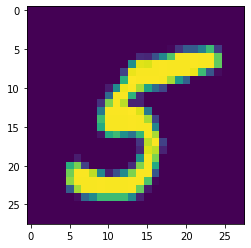

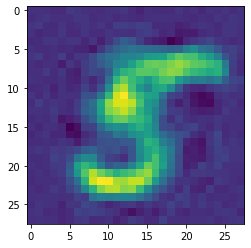

Nuisance image: 
Logits:  [9.7059848e-04 2.3734341e-03 1.2128591e-01 1.6605178e-01 4.8472823e-04
 5.4590288e-04 5.0983461e-05 6.2952822e-01 1.9582579e-02 5.9125967e-02]
Predicted:  7
Real:  7


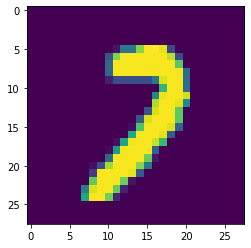

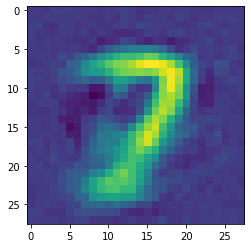

Metameric image
Logits:  [0.07235773 0.150147   0.10682242 0.05620126 0.05887968 0.14075842
 0.06245234 0.15049268 0.1456872  0.05620125]
Predicted class:  7


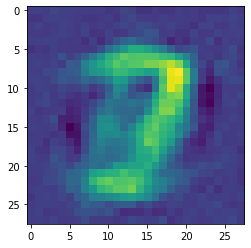


Logit image: 
Logits:  [3.4619417e-05 6.5248081e-04 2.2918892e-03 2.1003298e-03 1.9188124e-03
 2.5358873e-03 7.0174858e-05 1.1164061e-05 9.8893738e-01 1.4472696e-03]
Predicted:  8
Real:  8


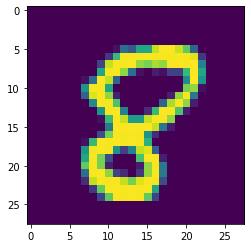

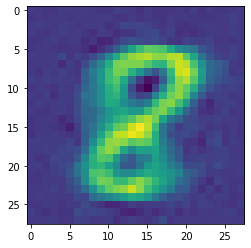

Nuisance image: 
Logits:  [4.2402487e-02 8.0931571e-04 7.5948648e-03 2.1773569e-02 2.0085282e-04
 8.5001123e-01 4.3898378e-02 6.1690566e-06 3.3167992e-02 1.3513574e-04]
Predicted:  5
Real:  5


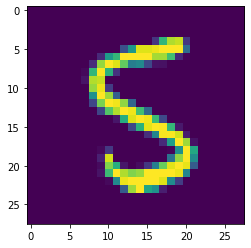

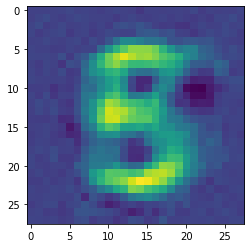

Metameric image
Logits:  [0.10422809 0.14841586 0.14777777 0.05467947 0.10880051 0.10561609
 0.06744731 0.06151047 0.14684498 0.05467946]
Predicted class:  1


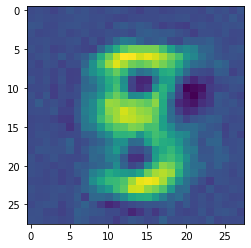


Logit image: 
Logits:  [2.2680682e-05 3.1593189e-04 1.1392829e-02 9.8596352e-01 1.4369176e-08
 9.2488923e-04 2.3909049e-06 1.3314359e-04 1.2054584e-03 3.9132236e-05]
Predicted:  3
Real:  3


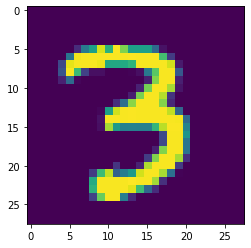

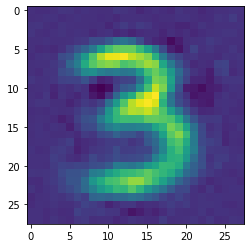

Nuisance image: 
Logits:  [3.7394072e-06 9.1384697e-01 3.3758115e-02 5.4815053e-03 4.6185716e-05
 3.6389873e-04 7.3153660e-06 2.1293055e-02 2.4506873e-02 6.9236534e-04]
Predicted:  1
Real:  1


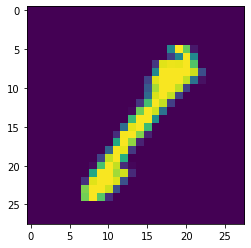

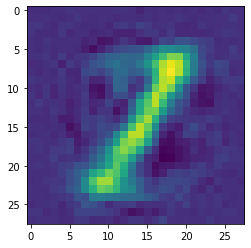

Metameric image
Logits:  [0.08111145 0.11769576 0.14660336 0.05649202 0.0581134  0.11606421
 0.0686867  0.1458545  0.1528866  0.05649201]
Predicted class:  8


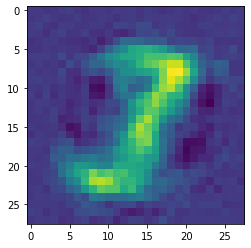


Logit image: 
Logits:  [2.96910410e-03 7.33459659e-04 2.53480882e-03 1.10738434e-01
 5.40121342e-04 7.75566459e-01 2.23414645e-05 3.88894044e-03
 2.97245886e-02 7.32817501e-02]
Predicted:  5
Real:  5


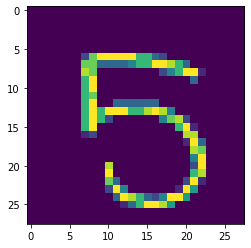

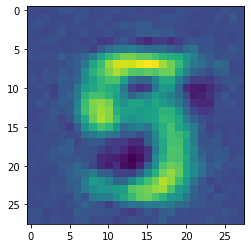

Nuisance image: 
Logits:  [5.7947102e-05 9.1773778e-01 6.7113355e-02 2.3383202e-03 3.6300604e-05
 1.0641076e-03 1.0162171e-03 8.9717666e-03 1.6009660e-03 6.3153013e-05]
Predicted:  1
Real:  1


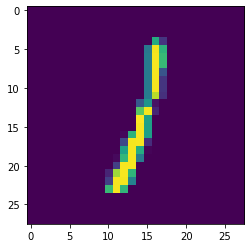

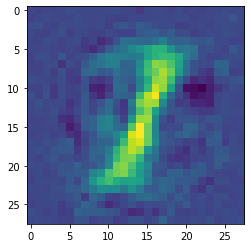

Metameric image
Logits:  [0.08380733 0.09821071 0.14541493 0.05700573 0.10114319 0.11079369
 0.06946882 0.13392797 0.1432219  0.05700572]
Predicted class:  2


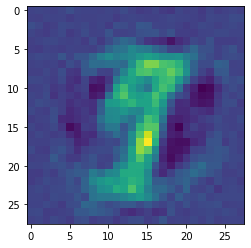


Logit image: 
Logits:  [1.00820425e-05 4.96564321e-02 6.68856323e-01 1.30958818e-02
 1.36967441e-02 2.58551154e-04 1.61550089e-03 2.04999849e-01
 8.70625488e-03 3.91043909e-02]
Predicted:  2
Real:  2


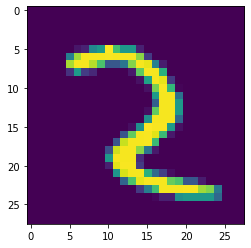

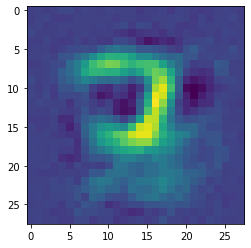

Nuisance image: 
Logits:  [1.8844208e-04 1.4132699e-03 4.9629651e-02 2.3781406e-04 8.0494946e-01
 2.9575434e-03 9.1198891e-02 2.5106606e-04 4.0323466e-02 8.8504385e-03]
Predicted:  4
Real:  4


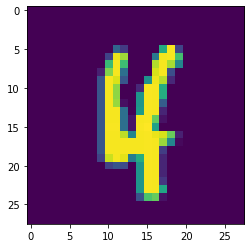

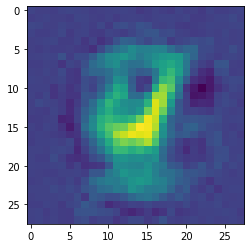

Metameric image
Logits:  [0.0758545  0.13386759 0.15338491 0.05659267 0.06998865 0.15319546
 0.12644179 0.10028076 0.07380106 0.05659266]
Predicted class:  2


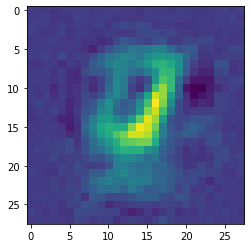


Logit image: 
Logits:  [9.9685353e-01 2.6727139e-06 7.5678242e-04 1.6889690e-05 1.4384508e-06
 6.9149717e-04 1.6629710e-03 2.9847006e-06 1.1103339e-05 1.6306971e-07]
Predicted:  0
Real:  0


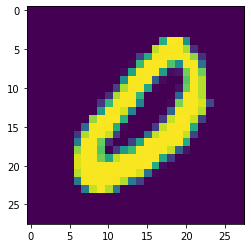

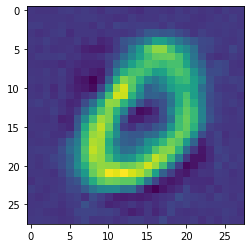

Nuisance image: 
Logits:  [3.8363103e-07 5.0728232e-02 6.0361094e-04 6.8732253e-03 3.6268952e-04
 1.4246273e-04 2.0712196e-06 8.8167232e-01 4.5057079e-03 5.5109277e-02]
Predicted:  7
Real:  7


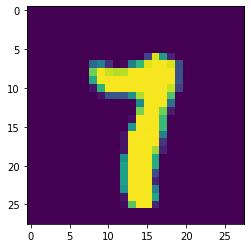

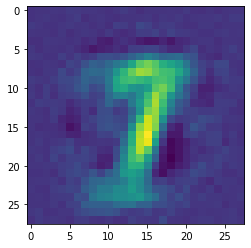

Metameric image
Logits:  [0.06853966 0.09378987 0.13955943 0.06000135 0.09161954 0.1547449
 0.07055893 0.15495948 0.10622555 0.06000134]
Predicted class:  7


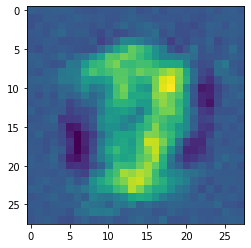


Logit image: 
Logits:  [1.5819319e-04 4.3905634e-03 2.0204719e-02 1.2109030e-02 1.3645288e-03
 6.1081164e-03 3.5162037e-04 7.8209210e-05 9.5342273e-01 1.8122960e-03]
Predicted:  8
Real:  8


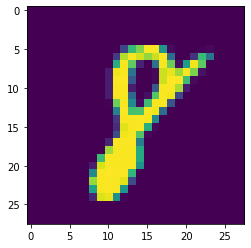

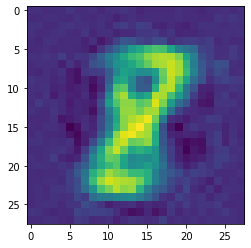

Nuisance image: 
Logits:  [9.9397027e-01 1.1827293e-06 1.3015124e-04 1.5445867e-04 6.6541537e-07
 5.4005822e-03 3.0461320e-04 2.1615290e-06 3.5147321e-05 7.1455054e-07]
Predicted:  0
Real:  0


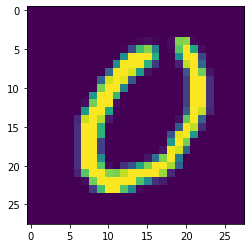

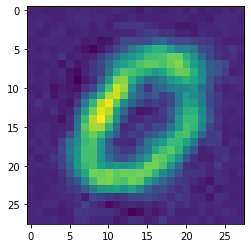

Metameric image
Logits:  [0.11563083 0.14901452 0.10262366 0.05484147 0.14669943 0.09249371
 0.0732588  0.06391326 0.14668283 0.05484145]
Predicted class:  1


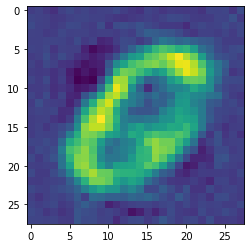


Logit image: 
Logits:  [3.8655973e-05 2.5072944e-05 3.8975861e-04 5.9670554e-03 1.3534189e-02
 2.6533250e-03 1.8363417e-05 5.9078015e-02 4.2875656e-03 9.1400796e-01]
Predicted:  9
Real:  9


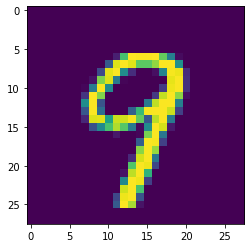

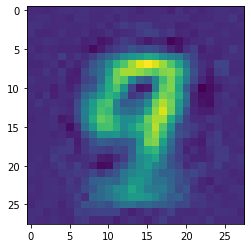

Nuisance image: 
Logits:  [4.2629177e-05 4.5746934e-04 1.2103872e-03 3.2036379e-03 2.1422373e-03
 4.1528535e-03 5.2894644e-05 2.1656228e-05 9.8542595e-01 3.2902127e-03]
Predicted:  8
Real:  8


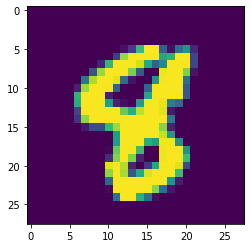

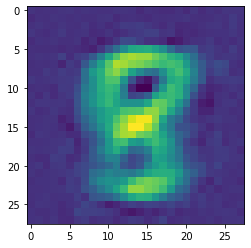

Metameric image
Logits:  [0.05897504 0.15593949 0.15431559 0.05742223 0.07912792 0.15453185
 0.063062   0.08081238 0.13839123 0.05742222]
Predicted class:  1


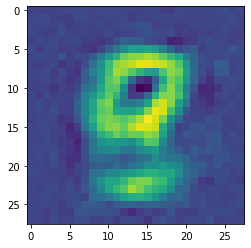


Logit image: 
Logits:  [1.5833849e-02 4.2905554e-05 1.5047507e-04 4.5487334e-04 3.8647808e-03
 1.7337429e-03 2.3303310e-05 8.9828610e-01 1.9454061e-04 7.9415418e-02]
Predicted:  7
Real:  7


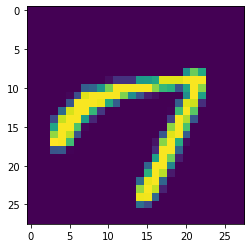

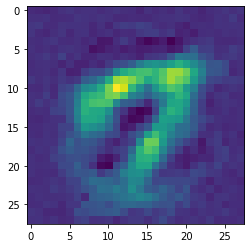

Nuisance image: 
Logits:  [9.9559963e-01 4.1429641e-07 1.2339483e-04 3.5627327e-05 5.1904063e-08
 3.8401284e-03 3.9769631e-04 4.5232515e-08 3.1072825e-06 1.4246812e-08]
Predicted:  0
Real:  0


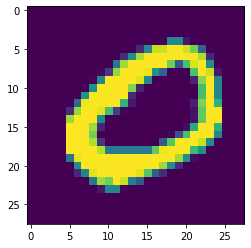

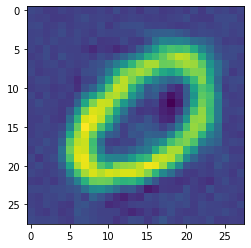

Metameric image
Logits:  [0.15452464 0.15923648 0.06082237 0.05858293 0.15923555 0.06286359
 0.07097662 0.06330945 0.15186551 0.05858291]
Predicted class:  1


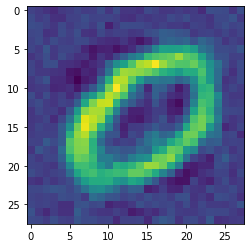


Logit image: 
Logits:  [5.1397708e-04 1.1996074e-04 1.8176485e-02 9.8002714e-01 9.2950170e-10
 9.4537018e-04 1.2893950e-06 7.8261786e-05 1.3412254e-04 3.3938518e-06]
Predicted:  3
Real:  3


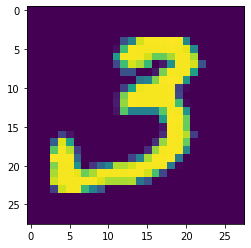

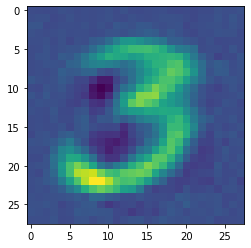

Nuisance image: 
Logits:  [4.7047856e-06 9.6791536e-01 2.5940333e-02 4.4760044e-04 3.1025302e-05
 1.6375034e-04 1.4556813e-04 3.6373995e-03 1.6822726e-03 3.1852745e-05]
Predicted:  1
Real:  1


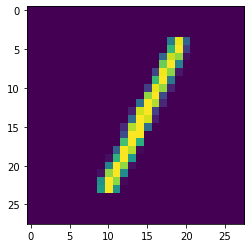

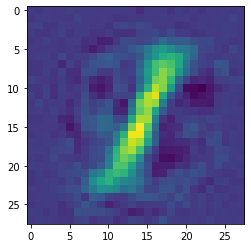

Metameric image
Logits:  [0.11822779 0.08394991 0.15148674 0.05778589 0.06499694 0.08729216
 0.07470196 0.14865509 0.15511774 0.05778588]
Predicted class:  8


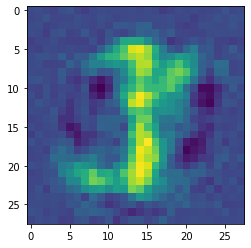

In [65]:
for _ in range(10):
  logit_img, nuisance_img = choose_images(model, test, 0.6)

  _, nuisance, _, _, _ = model(nuisance_img, training=False)
  logits, _, _, _, _ = model(logit_img, training=False)

  print("Metameric image")
  met_array = tf.concat([logits, nuisance], axis=-1)
  metameric_img = model._decoder(met_array)
  met_logits, _, _, _, _ = model(tf.reshape(metameric_img, (1, 28, 28, 1)), training=False)
  print("Logits: ", tf.nn.softmax(met_logits).numpy()[0])
  print("Predicted class: ", np.argmax(tf.nn.softmax(met_logits).numpy()[0]))
  plt.imshow(tf.reshape(metameric_img, (28, 28)).numpy())
  plt.show()
  print()

Logit image: 
Logits:  [9.9698836e-01 8.5088521e-07 3.4260951e-04 3.4122040e-05 5.1974080e-08
 2.3306690e-03 3.0113989e-04 1.6108658e-07 2.0117025e-06 1.7403158e-08]
Predicted:  0
Real:  0


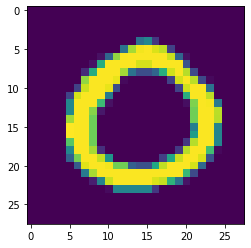

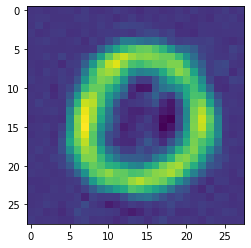

Nuisance image: 
Logits:  [3.7394038e-05 1.8548689e-04 5.2338393e-05 1.7907609e-04 2.7387968e-04
 3.9992883e-05 1.9412273e-06 9.8491633e-01 3.2859185e-05 1.4280705e-02]
Predicted:  7
Real:  7


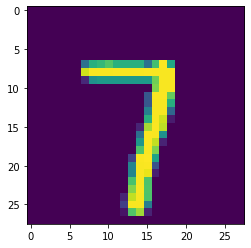

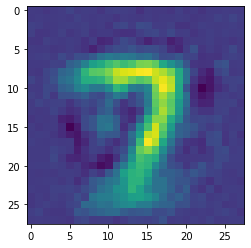

Metameric image
Logits:  [0.08755856 0.13341956 0.08312728 0.05931411 0.11950084 0.12492564
 0.06682868 0.15899903 0.10701226 0.05931409]
Predicted class:  7


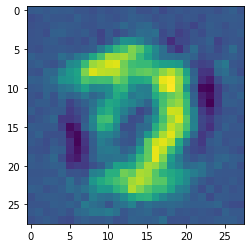


Logit image: 
Logits:  [1.6777402e-02 8.4752646e-05 1.1677810e-02 6.8707093e-05 4.9122064e-03
 6.9308141e-03 9.5914793e-01 1.1338762e-05 3.5348278e-04 3.5569756e-05]
Predicted:  6
Real:  6


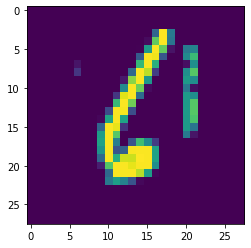

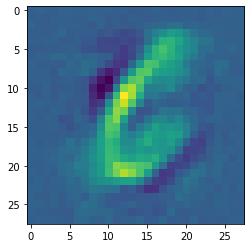

Nuisance image: 
Logits:  [2.0739641e-02 2.1982052e-04 1.9813245e-03 8.3105810e-02 2.6695370e-05
 8.8701761e-01 4.9007020e-05 2.8002894e-04 4.3426799e-03 2.2375104e-03]
Predicted:  5
Real:  5


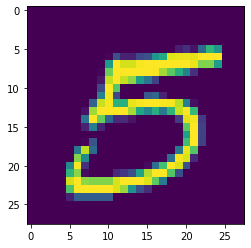

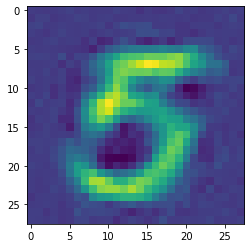

Metameric image
Logits:  [0.1162248  0.14731465 0.13315651 0.05424312 0.1440673  0.08508777
 0.06072506 0.06836142 0.13657628 0.05424311]
Predicted class:  1


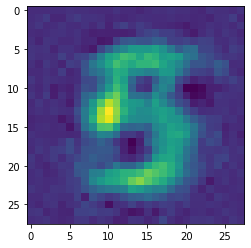


Logit image: 
Logits:  [9.9458015e-01 7.4348719e-07 1.3548440e-04 7.7027624e-04 2.2451925e-08
 4.4675935e-03 3.4367731e-05 6.0663401e-06 5.0348835e-06 3.8426691e-07]
Predicted:  0
Real:  0


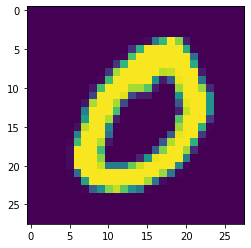

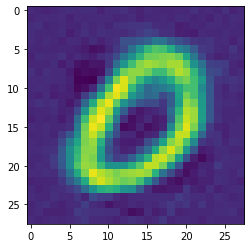

Nuisance image: 
Logits:  [1.02177975e-04 2.76510720e-04 2.41126586e-03 2.22209841e-03
 1.40747368e-01 4.62613069e-03 4.22961573e-04 1.08449370e-01
 4.90100123e-03 7.35841155e-01]
Predicted:  9
Real:  9


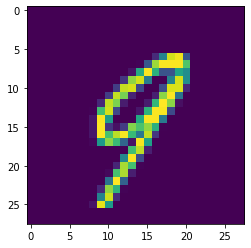

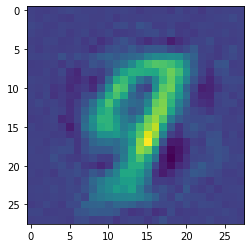

Metameric image
Logits:  [0.07439177 0.14532362 0.10088782 0.05528835 0.1258015  0.13065429
 0.06308834 0.13010713 0.11916882 0.05528834]
Predicted class:  1


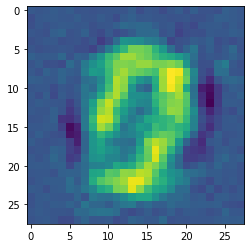


Logit image: 
Logits:  [1.94451350e-05 1.20712375e-05 4.37774986e-04 2.86571356e-03
 2.01754943e-02 8.91688687e-04 2.35534226e-05 7.29260817e-02
 1.41848030e-03 9.01229680e-01]
Predicted:  9
Real:  9


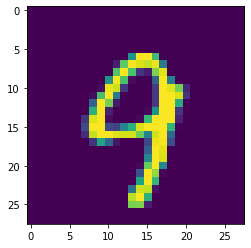

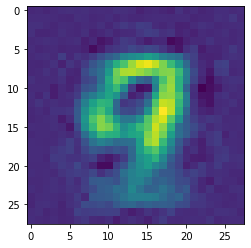

Nuisance image: 
Logits:  [9.9401051e-01 1.2540639e-06 2.5476556e-04 9.8536629e-04 2.4079943e-08
 4.6961657e-03 3.6019836e-05 1.0285760e-05 4.9262740e-06 4.6531710e-07]
Predicted:  0
Real:  0


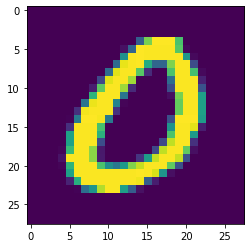

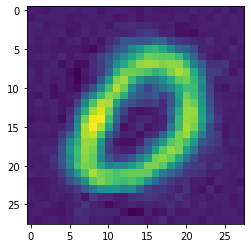

Metameric image
Logits:  [0.11620641 0.15165752 0.06053366 0.05579499 0.15023819 0.1110802
 0.06436083 0.10374213 0.13059108 0.05579497]
Predicted class:  1


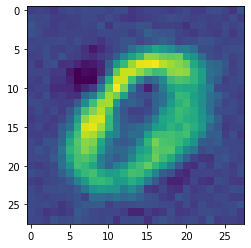


Logit image: 
Logits:  [5.2378905e-06 7.7349500e-04 3.8514550e-05 2.5590012e-04 1.0422390e-03
 1.4880500e-04 3.5225817e-06 9.4605714e-01 8.6719083e-05 5.1588397e-02]
Predicted:  7
Real:  7


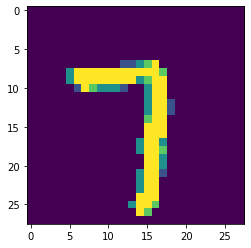

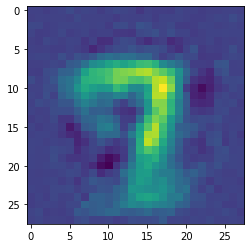

Nuisance image: 
Logits:  [9.9165452e-01 1.4545076e-06 2.8062720e-04 2.5473817e-03 1.4651898e-08
 5.4592253e-03 1.6517050e-05 3.4700006e-05 4.5783408e-06 9.8784756e-07]
Predicted:  0
Real:  0


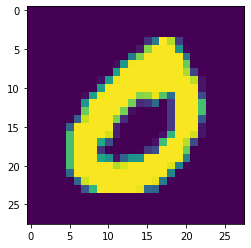

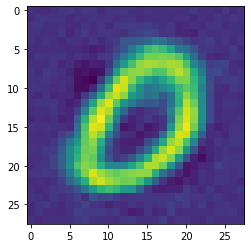

Metameric image
Logits:  [0.11616518 0.1511195  0.05671807 0.05560164 0.14973323 0.09976315
 0.05863433 0.12047706 0.13618618 0.05560162]
Predicted class:  1


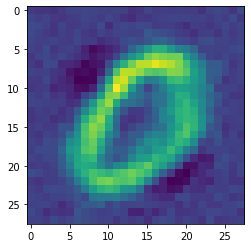


Logit image: 
Logits:  [1.5407151e-05 7.0318743e-04 1.2578069e-02 9.7745025e-01 1.2983726e-07
 2.3173562e-03 8.5063698e-07 2.8863587e-04 6.3313497e-03 3.1475449e-04]
Predicted:  3
Real:  3


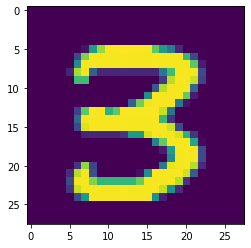

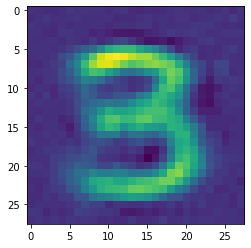

Nuisance image: 
Logits:  [2.4414346e-06 1.5132004e-02 1.7651829e-03 1.5626540e-02 3.2418259e-04
 1.3812854e-04 2.3697207e-06 8.9603126e-01 6.5739667e-03 6.4403877e-02]
Predicted:  7
Real:  7


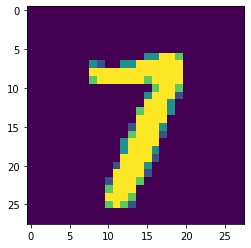

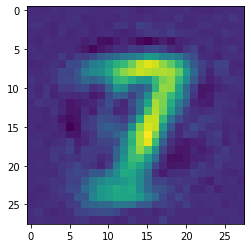

Metameric image
Logits:  [0.06347908 0.12540022 0.13272054 0.05843232 0.06009635 0.13277645
 0.05995828 0.15816139 0.15054311 0.05843231]
Predicted class:  7


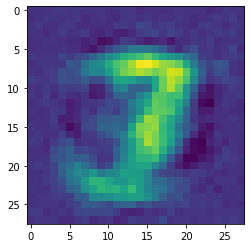


Logit image: 
Logits:  [4.1682856e-06 9.5847374e-01 3.5867982e-02 3.7120169e-03 2.6750538e-07
 9.8617886e-05 8.5309410e-05 1.2319580e-03 5.2396656e-04 2.1078245e-06]
Predicted:  1
Real:  1


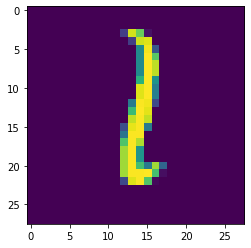

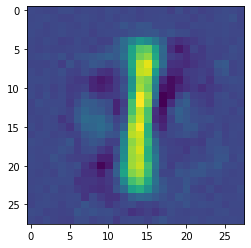

Nuisance image: 
Logits:  [6.78072625e-04 1.23863028e-05 4.38071229e-03 1.63821969e-05
 1.16786072e-02 7.67111895e-04 9.82315361e-01 4.47284719e-06
 1.03242186e-04 4.36565788e-05]
Predicted:  6
Real:  6


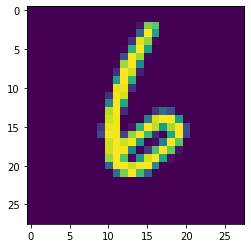

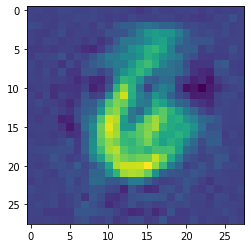

Metameric image
Logits:  [0.13495372 0.13282001 0.13638592 0.05044493 0.08404374 0.12419076
 0.12251959 0.08531584 0.0788806  0.05044492]
Predicted class:  2


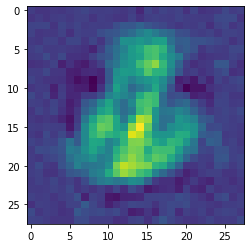


Logit image: 
Logits:  [4.9698563e-05 5.8158915e-03 3.0165587e-02 7.7654904e-01 1.6434076e-05
 5.3061186e-03 6.3756147e-06 4.4559618e-03 1.6948070e-01 8.1542758e-03]
Predicted:  3
Real:  3


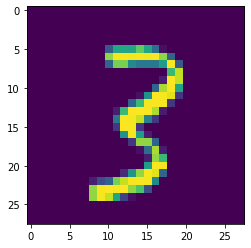

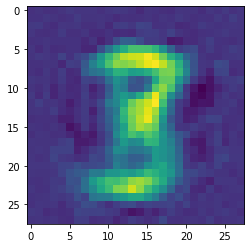

Nuisance image: 
Logits:  [5.9989503e-05 2.0825296e-06 6.9207759e-05 5.7897446e-06 9.7152936e-01
 1.4536973e-03 3.1666709e-03 5.9479418e-05 1.2275239e-03 2.2426138e-02]
Predicted:  4
Real:  4


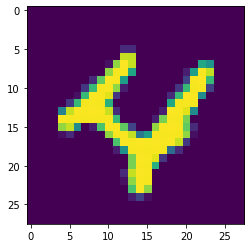

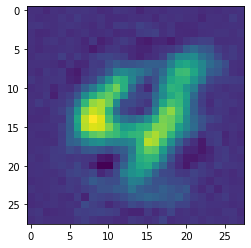

Metameric image
Logits:  [0.05726815 0.15021981 0.13818417 0.05559593 0.14031996 0.1469266
 0.06532532 0.09531    0.09525415 0.05559592]
Predicted class:  1


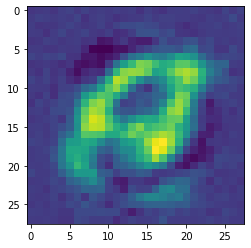


Logit image: 
Logits:  [2.8897126e-04 2.6016956e-04 1.1189112e-02 9.7843778e-01 1.5630915e-08
 9.0876631e-03 7.2411499e-06 5.0299986e-05 6.5662077e-04 2.2061662e-05]
Predicted:  3
Real:  3


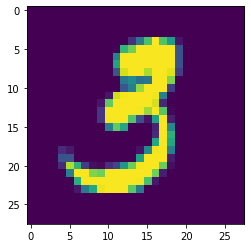

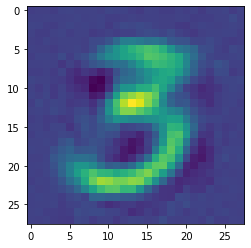

Nuisance image: 
Logits:  [5.38317690e-05 1.73664630e-05 3.73992923e-04 1.99235533e-03
 7.35763833e-02 3.37277888e-03 1.21148405e-04 2.74253152e-02
 3.55318352e-03 8.89513731e-01]
Predicted:  9
Real:  9


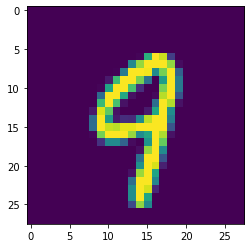

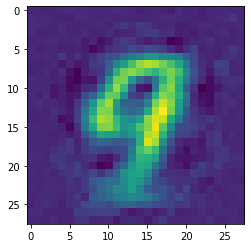

Metameric image
Logits:  [0.07269113 0.1483415  0.13279006 0.05485596 0.0954129  0.12115717
 0.05775898 0.13264543 0.12949094 0.05485594]
Predicted class:  1


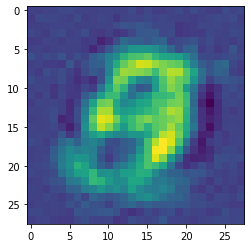


Logit image: 
Logits:  [5.2625114e-06 9.7639298e-01 1.3318221e-02 4.7995411e-03 1.6941317e-06
 4.1384951e-04 3.4541459e-05 2.5468047e-03 2.4676640e-03 1.9521116e-05]
Predicted:  1
Real:  1


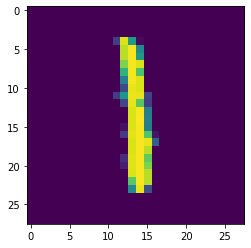

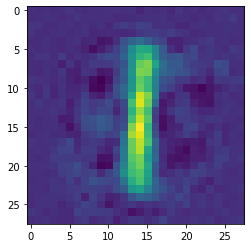

Nuisance image: 
Logits:  [1.1027907e-04 2.1589608e-03 9.7957772e-01 6.0005630e-03 7.4514945e-05
 1.3891120e-04 1.0311802e-02 2.9987626e-04 1.2725253e-03 5.4718184e-05]
Predicted:  2
Real:  2


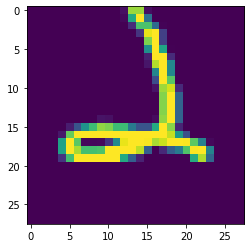

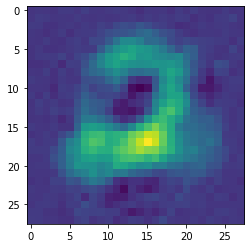

Metameric image
Logits:  [0.12333408 0.13027965 0.12645908 0.04814314 0.0533312  0.12682128
 0.12555654 0.11757272 0.1003592  0.04814313]
Predicted class:  1


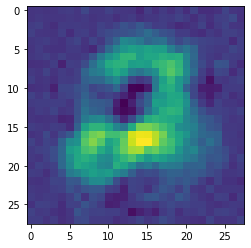

In [64]:
for _ in range(10):
  logit_img, nuisance_img = choose_images(model, test, 0.6)

  _, nuisance, _, _, _ = model(nuisance_img, training=False)
  logits, _, _, _, _ = model(logit_img, training=False)

  print("Metameric image")
  met_array = tf.concat([logits, nuisance], axis=-1)
  metameric_img = model._decoder(met_array)
  met_logits, _, _, _, _ = model(tf.reshape(metameric_img, (1, 28, 28, 1)), training=False)
  print("Logits: ", tf.nn.softmax(met_logits).numpy()[0])
  print("Predicted class: ", np.argmax(tf.nn.softmax(met_logits).numpy()[0]))
  plt.imshow(tf.reshape(metameric_img, (28, 28)).numpy())
  plt.show()
  print()

Защита:

In [52]:
def_model = RevNet()
def_model.build((1, 28, 28, 1))
def_model.summary()

Model: "rev_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 784)               1230880   
_________________________________________________________________
decoder (Sequential)         (None, 784)               1230880   
_________________________________________________________________
prediction (Sequential)      (None, 10)                110       
_________________________________________________________________
nuisance_prediction (Sequent (None, 10)                7750      
Total params: 2,469,620
Trainable params: 2,469,620
Non-trainable params: 0
_________________________________________________________________


Epoch:  20
Training loss mse: 7.995556075002241e-07, Training loss ce: 0.44457727670669556, Training acc over epoch: 0.869482159614563, Training loss ce nuisance: 43516.66796875
Val loss mse: 8.121601808852574e-07, Val loss ce: 0.48429569602012634, Val acc over epoch: 0.8561428785324097, Val loss ce nuisance: 44739.5234375


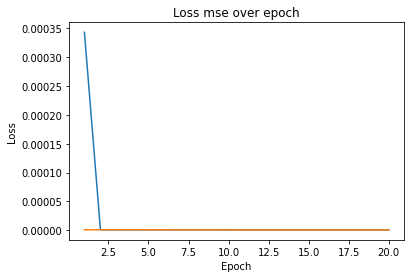

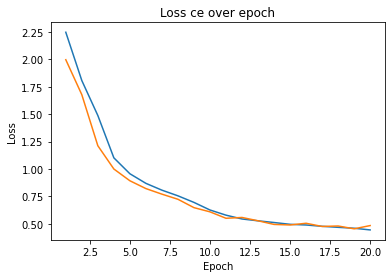

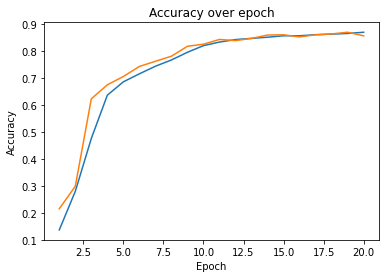

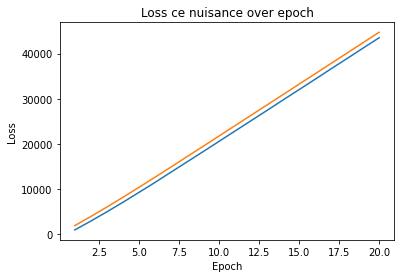

In [53]:
from IPython.display import clear_output
from tqdm import tqdm

max_val_acc = None

train_losses_mse = []
val_losses_mse = []

train_losses_ce = []
val_losses_ce = []

train_losses_ce_nuisance = []
val_losses_ce_nuisance = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

for epoch in range(20):
    train_mean_loss_mse = tf.keras.metrics.Mean()
    train_mean_loss_ce = tf.keras.metrics.Mean()
    train_mean_loss_ce_nuisance = tf.keras.metrics.Mean()
    val_mean_loss_mse = tf.keras.metrics.Mean()
    val_mean_loss_ce = tf.keras.metrics.Mean()
    val_mean_loss_ce_nuisance = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(len(X_train) / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        with tf.GradientTape() as tape:
          logits, nuisance, pred_logits, pred_images, pred_nuisance = def_model(x_batch_train, training=True)

          ce_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
          cross_ent = ce_fn(y_true=y_batch_train, y_pred=pred_logits)
          cross_ent_nuisance = ce_fn(y_true=y_batch_train, y_pred=pred_nuisance)

          mse = tf.keras.losses.MSE(pred_images, tf.reshape(x_batch_train, (-1, 28*28)))

          loss = mse + cross_ent - cross_ent_nuisance

        grads = tape.gradient(loss, def_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, def_model.trainable_variables))
        
        train_acc_metric(y_batch_train, pred_logits)
        train_mean_loss_mse(mse)
        train_mean_loss_ce(cross_ent)
        train_mean_loss_ce_nuisance(cross_ent_nuisance)

    for step in range(int(np.ceil(len(X_test) / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, nuisance, pred_logits, pred_images, pred_nuisance = def_model(x_batch_val, training=False)

        ce_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        cross_ent = ce_fn(y_true=y_batch_val, y_pred=pred_logits)
        cross_ent_nuisance = ce_fn(y_true=y_batch_val, y_pred=pred_nuisance)

        mse = tf.keras.losses.MSE(pred_images, tf.reshape(x_batch_val, (-1, 28*28)))

        val_acc_metric(y_batch_val, pred_logits)
        val_mean_loss_mse(mse)
        val_mean_loss_ce(cross_ent)
        val_mean_loss_ce_nuisance(cross_ent_nuisance)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss mse: %s, Training loss ce: %s, Training acc over epoch: %s, Training loss ce nuisance: %s' % (float(train_mean_loss_mse.result()), 
                                                                                        float(train_mean_loss_ce.result()),
                                                                                        float(train_acc_metric.result()),
                                                                                        float(train_mean_loss_ce_nuisance.result())))
    print('Val loss mse: %s, Val loss ce: %s, Val acc over epoch: %s, Val loss ce nuisance: %s' % (float(val_mean_loss_mse.result()),
                                                                         float(val_mean_loss_ce.result()),
                                                                         float(val_acc_metric.result()),
                                                                         float(val_mean_loss_ce_nuisance.result())))

    train_losses_mse.append(train_mean_loss_mse.result())
    val_losses_mse.append(val_mean_loss_mse.result())

    plt.plot(range(1, epoch + 2), train_losses_mse)
    plt.plot(range(1, epoch + 2), val_losses_mse)
    plt.title("Loss mse over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_losses_ce.append(train_mean_loss_ce.result())
    val_losses_ce.append(val_mean_loss_ce.result())

    plt.plot(range(1, epoch + 2), train_losses_ce)
    plt.plot(range(1, epoch + 2), val_losses_ce)
    plt.title("Loss ce over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    train_losses_ce_nuisance.append(train_mean_loss_ce_nuisance.result())
    val_losses_ce_nuisance.append(val_mean_loss_ce_nuisance.result())

    plt.plot(range(1, epoch + 2), train_losses_ce_nuisance)
    plt.plot(range(1, epoch + 2), val_losses_ce_nuisance)
    plt.title("Loss ce nuisance over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        def_model.save_weights("drive/My Drive/Диплом/mnist_def.hdf5")
        max_val_acc = float(val_acc_metric.result())

    def_model.save_weights("drive/My Drive/Диплом/curr_mnist_def.hdf5")